In [58]:
# | exporti


import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import numpyro
import numpyro.distributions as dist
import polars as pl
import seaborn as sns
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from tqdm import tqdm

from bayesianfin.data import (
    DataLoader,
    FeatureEngineer,
    LogReturn,
    Variance,
    append_from_log_ret,
)

In [59]:
# | export
az.style.use("arviz-darkgrid")

In [60]:
# | exec: false
# Create a data loader with default parameters and load the data
data_loader = DataLoader(max_records=9000)
source_df = data_loader.load_data("./data/ng_daily.csv")
source_df.head()

date,price,ret
date,f64,f64
1997-01-07,3.82,null
1997-01-08,3.8,0.994764
1997-01-09,3.61,0.95
1997-01-10,3.92,1.085873
1997-01-13,4.0,1.020408


In [61]:
# | exec: false
feature_engineer = FeatureEngineer(
    transforms=[
        LogReturn(source_field="ret", feature_name="log_ret"),
        Variance(source_field="price", feature_name="var"),
        LogReturn(source_field="var", feature_name="log_var"),
    ],
    n_shifts=2,
)
df_with_features = feature_engineer.create_features(source_df)
df_with_features = df_with_features.with_row_index()
df_with_features = df_with_features.filter(pl.col("ret") != 1)
df_with_features

index,date,price,ret,log_ret,var,log_var,prev_log_ret_1,prev_log_ret_2,prev_var_1,prev_var_2,prev_log_var_1,prev_log_var_2
u32,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,1997-01-14,4.01,1.0025,0.002497,0.002433,-6.018493,0.020203,0.082384,0.042433,0.024433,-3.159821,-3.711807
1,1997-01-15,4.34,1.082294,0.079083,0.037433,-3.285194,0.002497,0.020203,0.002433,0.042433,-6.018493,-3.159821
2,1997-01-16,4.71,1.085253,0.081814,0.122633,-2.098556,0.079083,0.002497,0.037433,0.002433,-3.285194,-6.018493
3,1997-01-17,3.91,0.830149,-0.186151,0.1603,-1.830708,0.081814,0.079083,0.122633,0.037433,-2.098556,-3.285194
4,1997-01-20,3.26,0.83376,-0.18181,0.5275,-0.639606,-0.186151,0.081814,0.1603,0.122633,-1.830708,-2.098556
…,…,…,…,…,…,…,…,…,…,…,…,…
6435,2025-02-04,3.25,0.984848,-0.015267,0.0403,-3.211404,0.11892,-0.062831,0.034233,0.051033,-3.374555,-2.975276
6436,2025-02-05,3.22,0.990769,-0.009274,0.001633,-6.417132,-0.015267,0.11892,0.0403,0.034233,-3.211404,-3.374555
6437,2025-02-06,3.31,1.02795,0.027567,0.0021,-6.165818,-0.009274,-0.015267,0.001633,0.0403,-6.417132,-3.211404


In [62]:
# Cut-off point
T = 300
drop_cols = {}
present_log_ret_train, present_log_var_train, present_log_ret_test = (
    df_with_features["log_ret"][:-T].to_numpy(),
    df_with_features["log_var"][:-T].to_numpy(),
    df_with_features["log_ret"][-T:].to_numpy(),
)
past_values_train, past_values_test = (
    feature_engineer.to_numpy_dict(df_with_features[:-T], drop=drop_cols),
    feature_engineer.to_numpy_dict(df_with_features[-T:], drop=drop_cols),
)

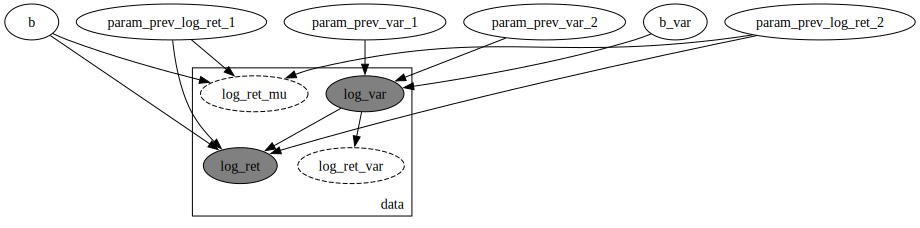

In [63]:
# | export
def garch_like_sample_vol_model(
    log_ret_value: npt.NDArray | None,
    log_var_value: npt.NDArray | None,
    past_values: dict[str, npt.NDArray],
    strict_sampling: bool = True,
) -> None:
    if strict_sampling and log_ret_value is None:
        assert log_var_value is None, (
            "in strict mode, both log var and log ret must be None"
        )
    def_spread = 0.5
    b = numpyro.sample("b", dist.Normal(0, def_spread))
    b_var = numpyro.sample("b_var", dist.Normal(-5, def_spread))

    coeffs = {}
    for col, s in feature_engineer.get_iterator("log_ret"):
        param_name = feature_engineer.get_shift_pattern(col, s)
        coeffs[param_name] = numpyro.sample(
            f"param_{param_name}", dist.Normal(0.0, def_spread)
        )

    for col, s in feature_engineer.get_iterator("var"):
        param_name = feature_engineer.get_shift_pattern(col, s)
        coeffs[param_name] = numpyro.sample(
            f"param_{param_name}", dist.Normal(0.0, def_spread)
        )

    # Handle prediction case
    len_observations = len(log_ret_value) if log_ret_value is not None else 1
    # sigma_log_var = numpyro.sample("sigma_log_var", dist.Exponential(10.0))
    with numpyro.plate("data", len_observations):
        mu = b
        for col, s in feature_engineer.get_iterator("log_ret"):
            param_name = feature_engineer.get_shift_pattern(col, s)
            mu += coeffs[param_name] * past_values[param_name]

        mu_log_var = b_var
        for col, s in feature_engineer.get_iterator("var"):
            param_name = feature_engineer.get_shift_pattern(col, s)
            mu_log_var += coeffs[param_name] * past_values[param_name]

        log_var = numpyro.sample(
            "log_var", dist.Normal(mu_log_var, 0.1), obs=log_var_value
        )
        std = jnp.exp(log_var / 2)
        # Condition on observed values if provided
        numpyro.deterministic("log_ret_mu", mu)
        numpyro.deterministic("log_ret_var", log_var)
        numpyro.sample("log_ret", dist.Normal(mu, std), obs=log_ret_value)


numpyro.render_model(
    garch_like_sample_vol_model,
    model_args=(
        present_log_ret_train,
        present_log_var_train,
        past_values_train,
    ),
)

In [64]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(garch_like_sample_vol_model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples)

mcmc.run(
    rng_key_,
    log_ret_value=present_log_ret_train,
    log_var_value=present_log_var_train,
    past_values=past_values_train,
)
mcmc.print_summary()
posterior_samples = mcmc.get_samples()
print(posterior_samples.keys())

sample: 100%|██████████| 3000/3000 [00:03<00:00, 863.27it/s, 31 steps of size 1.35e-01. acc. prob=0.91] 



                            mean       std    median      5.0%     95.0%     n_eff     r_hat
                     b     -0.00      0.00     -0.00     -0.00      0.00   2274.70      1.00
                 b_var     -5.01      0.00     -5.01     -5.01     -5.01   1957.84      1.00
  param_prev_log_ret_1     -0.26      0.03     -0.26     -0.31     -0.21    890.90      1.00
  param_prev_log_ret_2     -0.02      0.01     -0.02     -0.04      0.00    728.23      1.00
      param_prev_var_1      0.12      0.00      0.12      0.11      0.12   1760.54      1.00
      param_prev_var_2      0.05      0.00      0.05      0.05      0.06   1772.41      1.00

Number of divergences: 0
dict_keys(['b', 'b_var', 'log_ret_mu', 'log_ret_var', 'param_prev_log_ret_1', 'param_prev_log_ret_2', 'param_prev_var_1', 'param_prev_var_2'])


In [65]:
posterior_predictive = Predictive(
    garch_like_sample_vol_model,
    posterior_samples=posterior_samples,
    num_samples=1,
)
posterior_predictions = posterior_predictive(
    rng_key,
    log_ret_value=None,
    log_var_value=None,
    past_values=past_values_train,
)
posterior_predictions.keys()

/var/folders/8s/q13s1_m56g3b3k_1fmdrwn_80000gn/T/ipykernel_49234/149760613.py:1: UserWarning: Sample's batch dimension size 2000 is different from the provided 1 num_samples argument. Defaulting to 2000.
  posterior_predictive = Predictive(


dict_keys(['log_ret', 'log_ret_mu', 'log_ret_var', 'log_var'])

In [66]:
min_ind = posterior_predictions["log_ret"][0].argmin()
print(posterior_predictions["log_ret"][0][min_ind])
posterior_predictions["log_var"][0][min_ind]

-184.99852


Array(10.289137, dtype=float32)

(-1.0, 1.0)

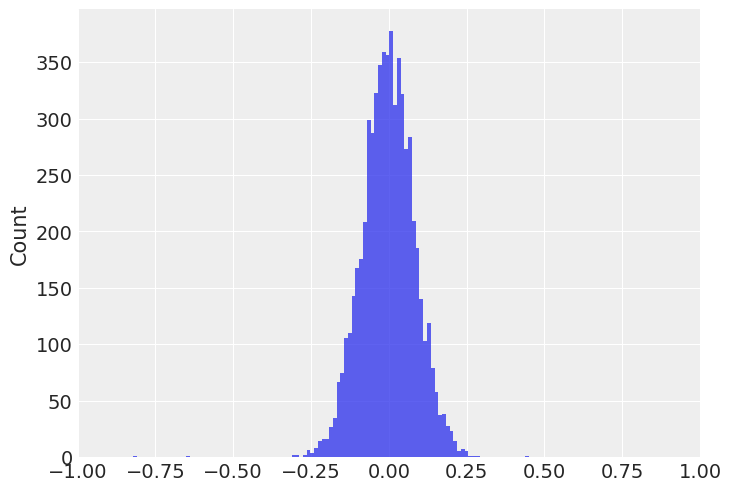

In [67]:
sns.histplot(posterior_predictions["log_ret"][0])
plt.xlim([-1, 1])

<Axes: ylabel='Count'>

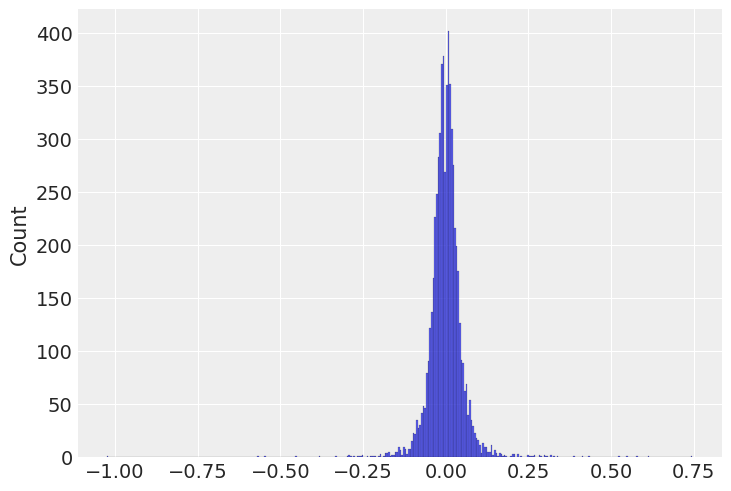

In [68]:
sns.histplot(present_log_ret_train)

<Axes: xlabel='log_ret'>

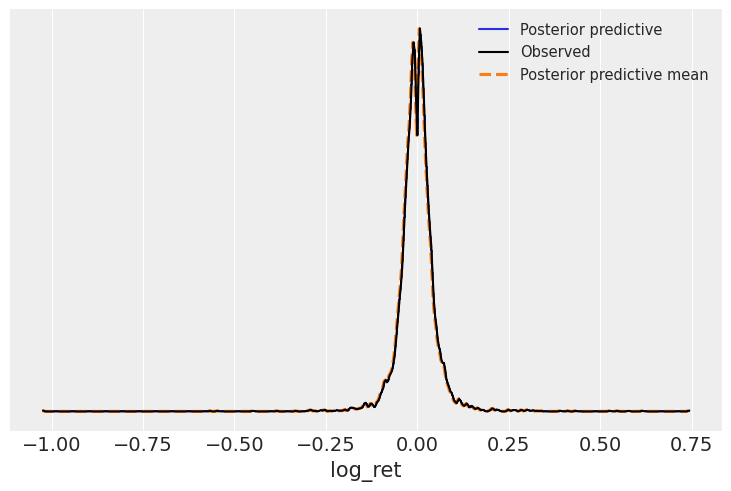

In [69]:
predictive = Predictive(
    garch_like_sample_vol_model,
    posterior_samples=posterior_samples,
)
rng_key, rng_key_ppc = random.split(rng_key)
ppc_samples = predictive(
    rng_key_ppc,
    log_ret_value=present_log_ret_train,
    log_var_value=present_log_var_train,
    past_values=past_values_train,
)
prior_samples = Predictive(garch_like_sample_vol_model, num_samples=2000)(
    rng_key,
    log_ret_value=present_log_ret_train,
    log_var_value=present_log_var_train,
    past_values=past_values_train,
)

idata = az.from_numpyro(
    mcmc,
    posterior_predictive=ppc_samples,
    prior=prior_samples,
)
az.plot_ppc(idata, var_names=["log_ret"])

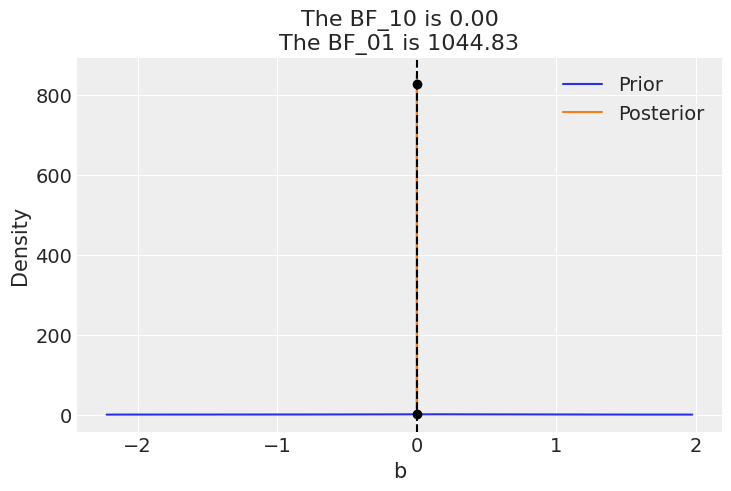

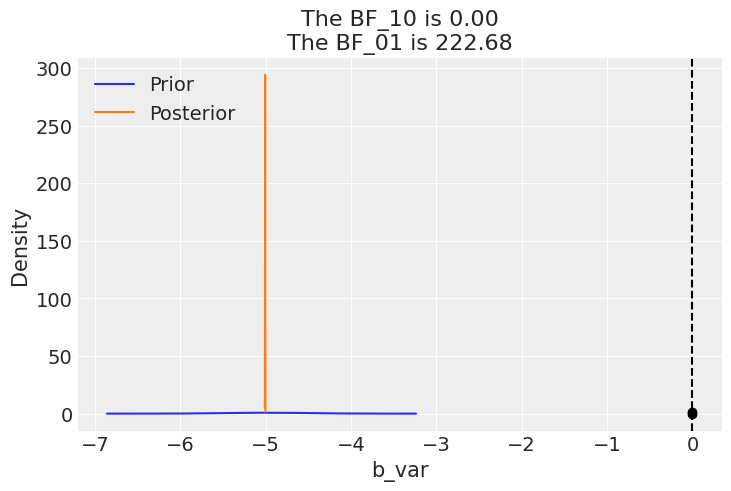

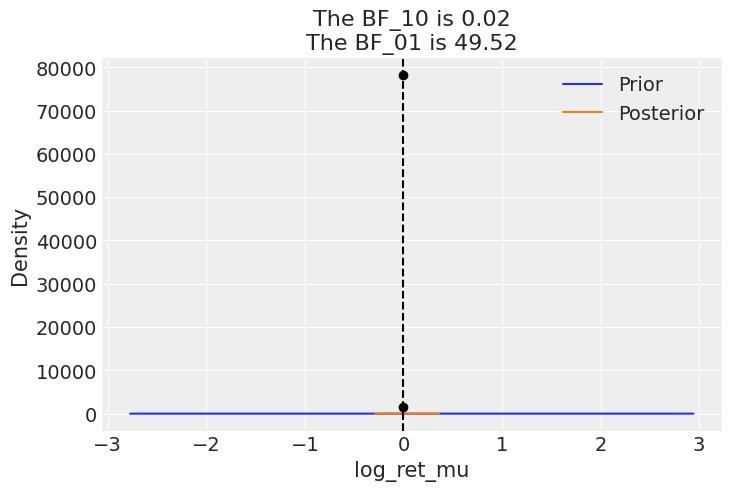

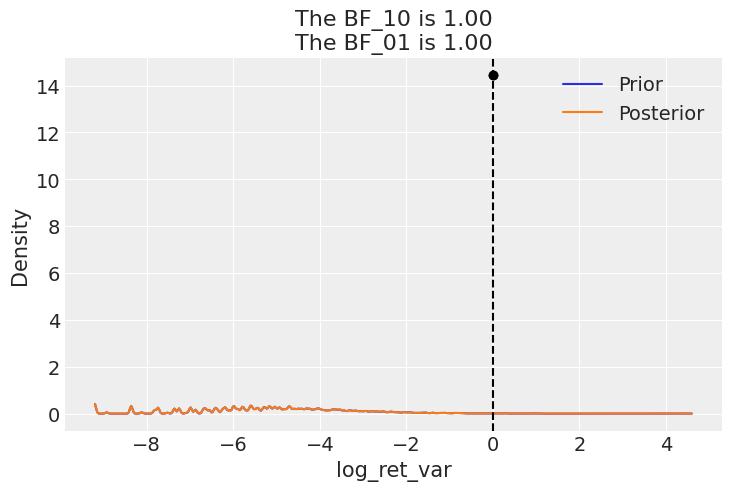

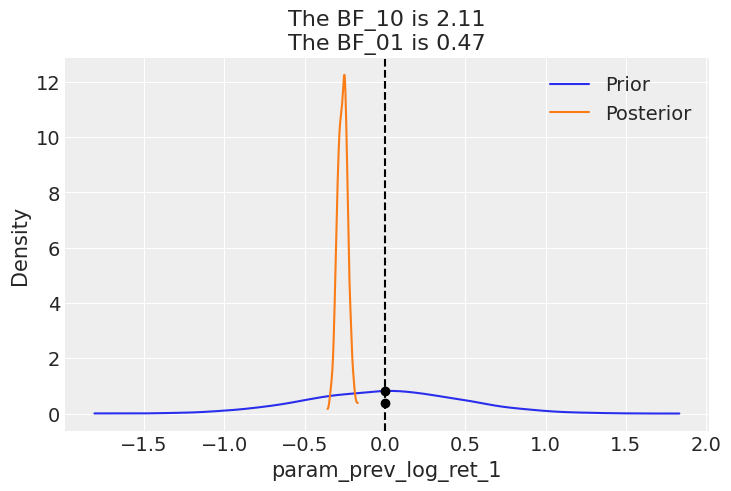

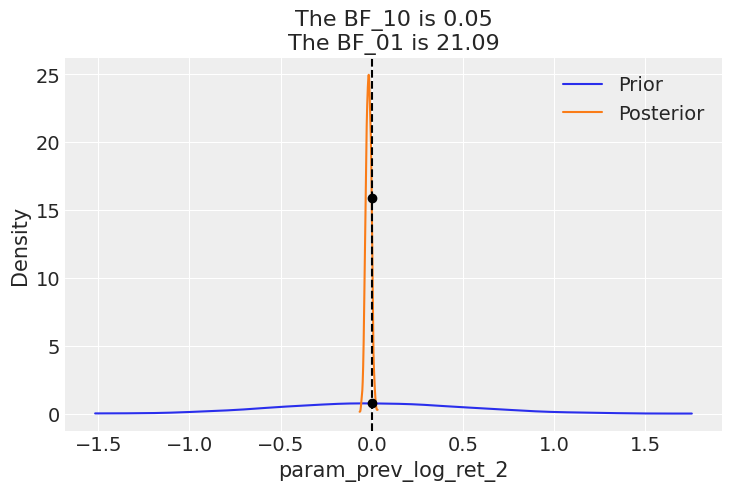

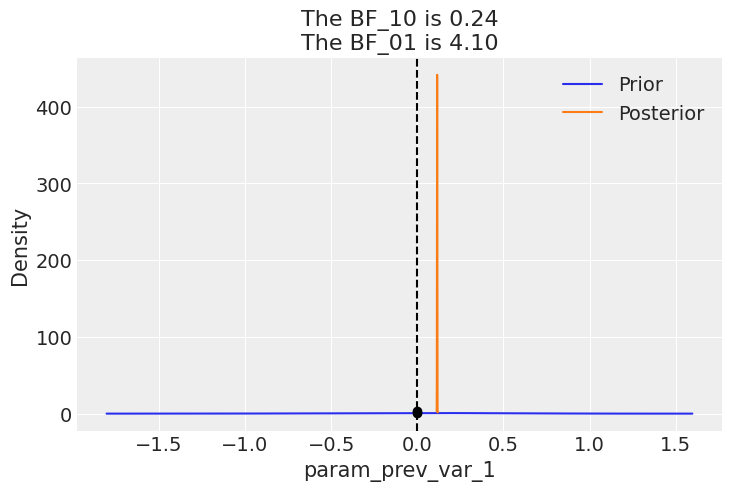

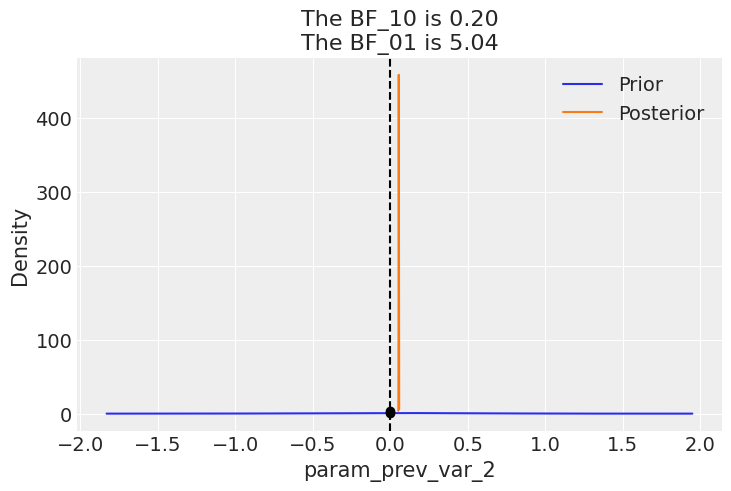

In [70]:
for k in posterior_samples.keys():
    az.plot_bf(idata, var_name=k)

In [71]:
# az.plot_forest(posterior_samples)

In [72]:
# az.plot_trace(idata);

In [73]:
num_sims = 500
all_trajectories = []
posterior_sample_indices = np.random.choice(num_samples, size=num_sims, replace=False)
# We want a single sample when going through the auto-regressive part
target_site = "log_ret"

# Generate some randomness for sampling
rng_key = random.PRNGKey(1)
rng_key, sim_key = random.split(rng_key)
for sim_id, idx in tqdm(enumerate(posterior_sample_indices), total=num_sims):
    sim_key, traj_key = random.split(sim_key)

    # Create the predictive object to actually sample log returns
    posterior_draw = {k: v[idx : idx + 1] for k, v in posterior_samples.items()}
    prior_predictive = Predictive(
        garch_like_sample_vol_model,
        posterior_samples=posterior_draw,
        num_samples=1,
    )
    # Init the starting price and the features
    starting_sim_df = source_df[-T - feature_engineer.n_shifts * 5 - 50 : -T]
    feature_sim_df = feature_engineer.create_features(starting_sim_df)
    current_price_shifts = feature_engineer.to_numpy_dict(
        feature_sim_df[-1], drop=drop_cols
    )
    log_vars = []
    for t in range(min(T, 30)):
        traj_key, step_key = random.split(traj_key)
        prior_predictions = prior_predictive(
            step_key,
            log_ret_value=None,
            log_var_value=None,
            past_values=current_price_shifts,
        )
        new_log_ret = prior_predictions[target_site].squeeze().item()
        log_vars.append(prior_predictions["log_var"].squeeze().item())
        starting_sim_df = append_from_log_ret(starting_sim_df, new_log_ret=new_log_ret)

        # With the new record attached, we re-extract the features.
        feature_sim_df = feature_engineer.create_features(starting_sim_df)
        current_price_shifts = feature_engineer.to_numpy_dict(feature_sim_df[-1])
    all_trajectories.append(starting_sim_df.with_columns(run_id=pl.lit(sim_id)))
all_runs = pl.concat(all_trajectories)

100%|██████████| 500/500 [00:39<00:00, 12.57it/s]


<Axes: xlabel='date', ylabel='log_ret'>

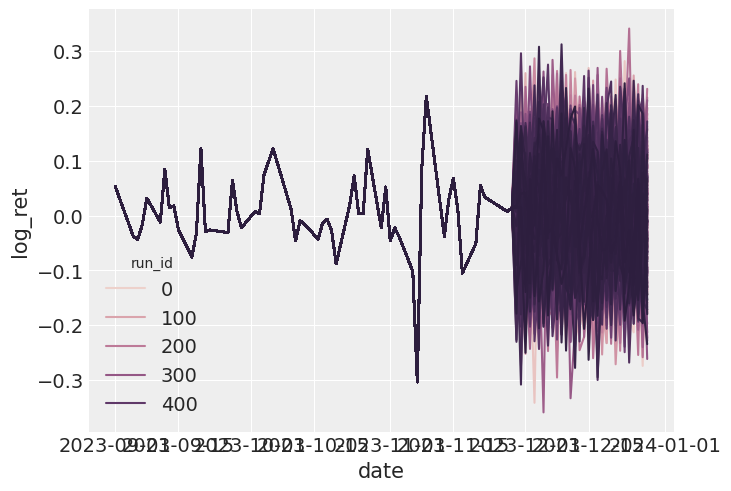

In [74]:
sns.lineplot(
    feature_engineer.create_features(all_runs), x="date", y="log_ret", hue="run_id"
)

<Axes: >

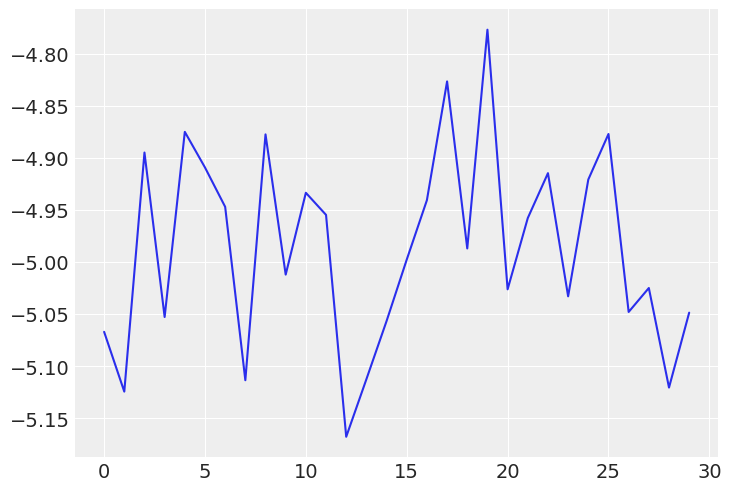

In [75]:
sns.lineplot(np.array(log_vars))

<Axes: >

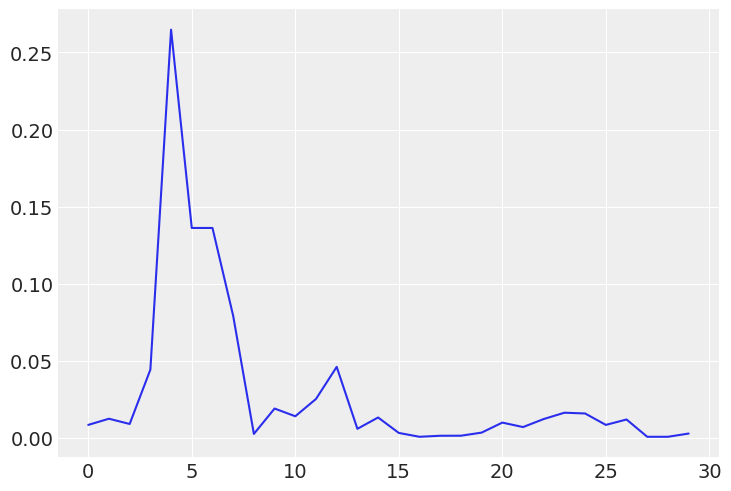

In [76]:
sns.lineplot(np.exp(past_values_test["log_var"][:30]))

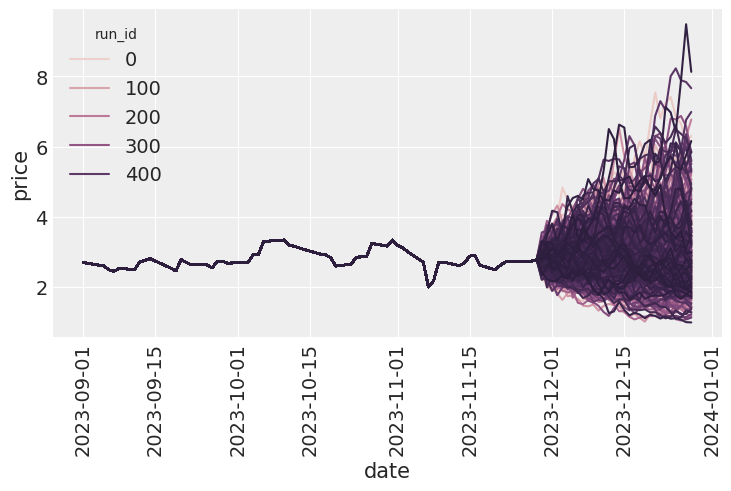

In [77]:
sns.lineplot(all_runs, x="date", y="price", hue="run_id")
plt.xticks(rotation=90);
# plt.ylim([0, 40])

<Axes: ylabel='Count'>

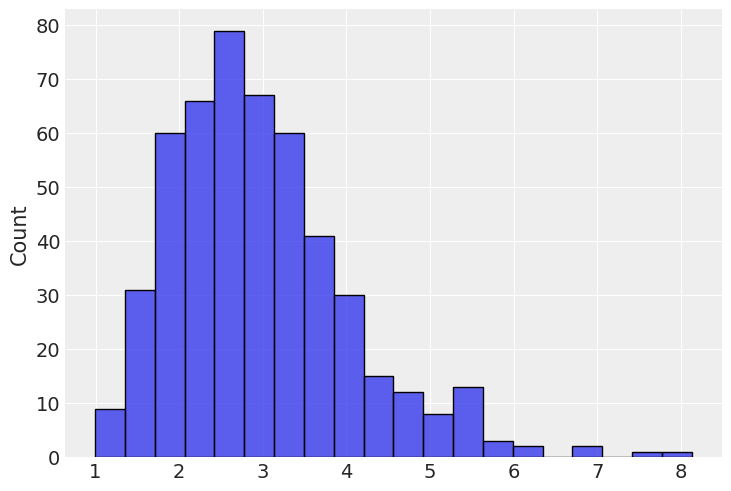

In [78]:
last_prices = (
    all_runs.sort("date")  # Ensure dates are in correct order
    .group_by("run_id")
    .agg(pl.col("price").last())  # Get the last price for each run
    .rename({"price": "final_price"})
)
sns.histplot(last_prices["final_price"], bins=20)